In [1]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk(r'C:\Users\ayush\Downloads\archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break


C:\Users\ayush\Downloads\archive\test\angry\PrivateTest_10131363.jpg
C:\Users\ayush\Downloads\archive\test\disgust\PrivateTest_11895083.jpg
C:\Users\ayush\Downloads\archive\test\fear\PrivateTest_10153550.jpg
C:\Users\ayush\Downloads\archive\test\happy\PrivateTest_10077120.jpg
C:\Users\ayush\Downloads\archive\test\neutral\PrivateTest_10086748.jpg
C:\Users\ayush\Downloads\archive\test\sad\PrivateTest_10247676.jpg
C:\Users\ayush\Downloads\archive\test\surprise\PrivateTest_10072988.jpg
C:\Users\ayush\Downloads\archive\train\angry\Training_10118481.jpg
C:\Users\ayush\Downloads\archive\train\disgust\Training_10371709.jpg
C:\Users\ayush\Downloads\archive\train\fear\Training_10018621.jpg
C:\Users\ayush\Downloads\archive\train\happy\Training_10019449.jpg
C:\Users\ayush\Downloads\archive\train\neutral\Training_10002154.jpg
C:\Users\ayush\Downloads\archive\train\sad\Training_10022789.jpg
C:\Users\ayush\Downloads\archive\train\surprise\Training_10013223.jpg


### Installing Necessary Libraries

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

C:\Users\ayush\AppData\Local\Temp\ipykernel_5360\3330320704.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
project_name = 'ML_Face_Recog_To_Detect_Mood'

model_names = [
    'Custom_CNN_From_Scratch'
]

base_dir = r'D:\LGM\T4'
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)


project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: D:\LGM\T4\ML_Face_Recog_To_Detect_Mood


### Data Cleaning

In [5]:
# list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = r'C:\Users\ayush\Downloads\archive\train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

### Data Analysis

In [6]:
# This function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = r'C:\Users\ayush\Downloads\archive\train'
test_dir = r'C:\Users\ayush\Downloads\archive\test'

# Count the files in the subdirectories of the training directory and testing directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<Axes: >

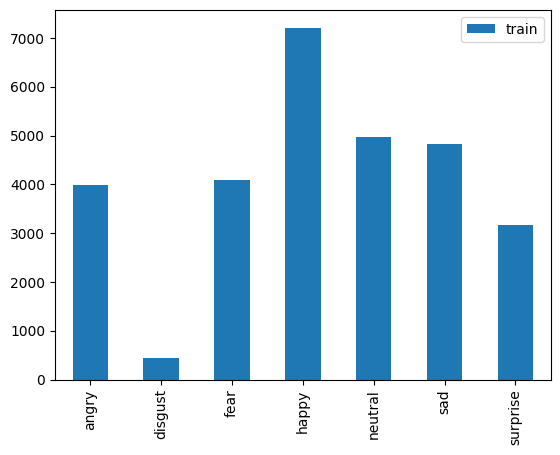

In [7]:
train_count.transpose().plot(kind='bar')

<Axes: >

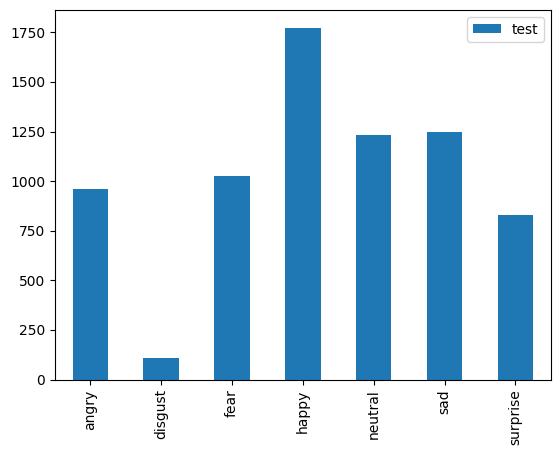

In [8]:
test_count.transpose().plot(kind='bar')

### Plotting Single Image from Each Emotion Category

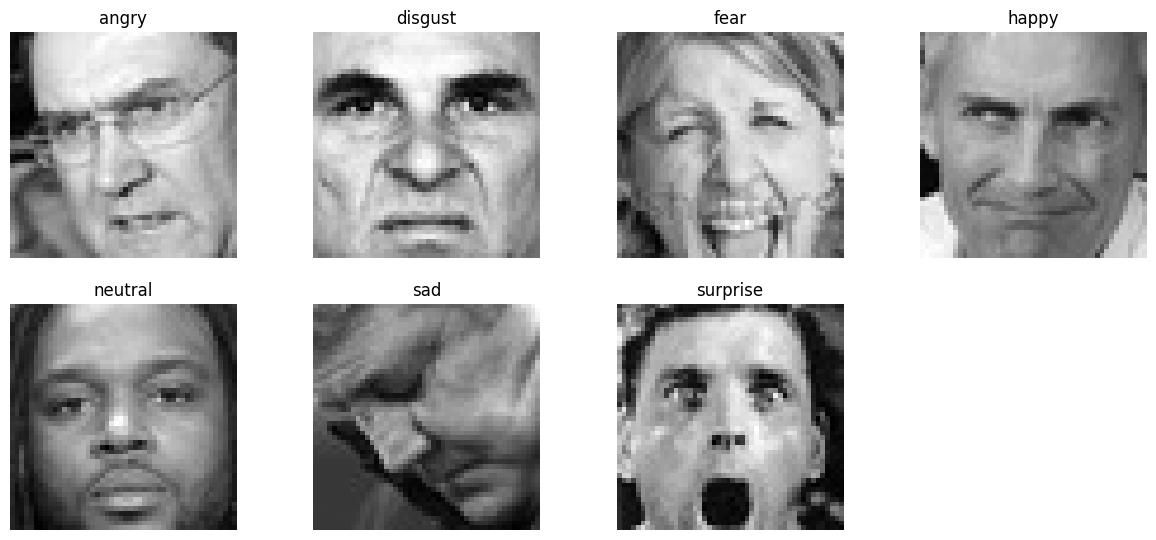

In [9]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

### Plotting random images from images directory

In [10]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

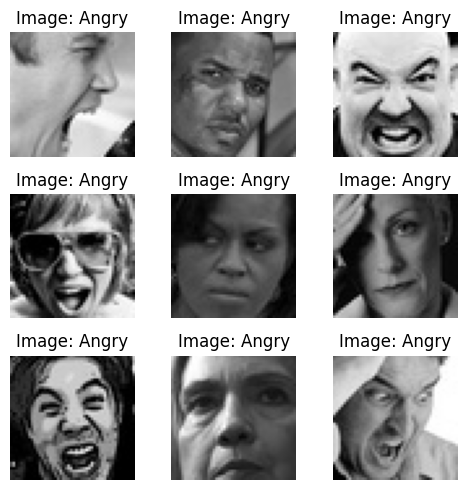

In [11]:
angry_directory_path = r'C:\Users\ayush\Downloads\archive\train\angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

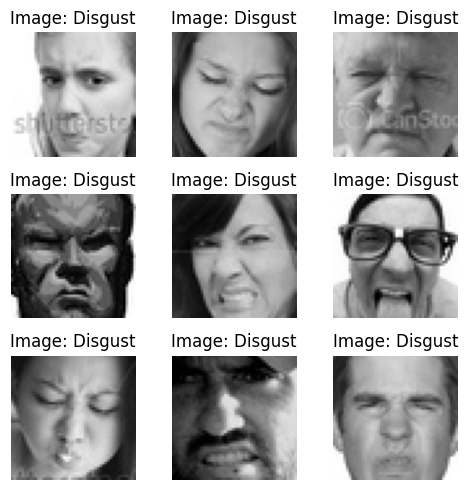

In [12]:
disgust_directory_path = r'C:\Users\ayush\Downloads\archive\train\disgust'
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

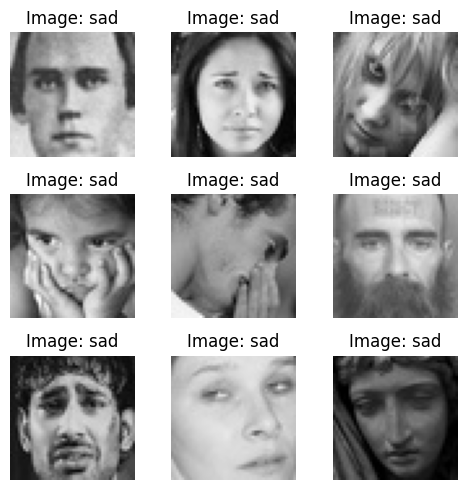

In [13]:
sad_directory_path = r'C:\Users\ayush\Downloads\archive\train\sad'
plot_images_from_directory(sad_directory_path, class_name = 'sad')

### Checking Shapes and Channels

In [14]:
image = r'C:\Users\ayush\Downloads\archive\train\angry\Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Loading in RGB channels

if img is not None:
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [15]:
import cv2

image_path = r'C:\Users\ayush\Downloads\archive\train\angry\Training_10118481.jpg'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is not None:
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


### Model 1 : Custom CNN MODEL

In [16]:
# paths to the train and test directories
train_data_dir =r'C:\Users\ayush\Downloads\archive\train'

test_data_dir = r'C:\Users\ayush\Downloads\archive\test'

In [17]:
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7

In [18]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [20]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal',input_shape=(img_width,img_height,1)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(num_classes,activation='softmax'))

c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [22]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Callbacks

In [23]:
# File path for the model checkpoint
cnn_path = r'D:\LGM\T4\ML_Face_Recog_To_Detect_Mood\Custom_CNN_From_Scratch\saved_models'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)


# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(r'D:\LGM\T4\ML_Face_Recog_To_Detect_Mood\Custom_CNN_From_Scratch\logs','training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [24]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size
test_steps_epoch = test_generator.samples // test_generator.batch_size

print("Training Steps per EPOCH : ",train_steps_per_epoch)
print("Validation Steps per EPOCH : ",validation_steps_epoch)
print("Testing Steps per EPOCH : ",test_steps_epoch)

Training Steps per EPOCH :  358
Validation Steps per EPOCH :  89
Testing Steps per EPOCH :  112


In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=31,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/31


c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.2412 - loss: 13.3361
Epoch 1: val_loss improved from inf to 15.14122, saving model to D:\LGM\T4\ML_Face_Recog_To_Detect_Mood\Custom_CNN_From_Scratch\saved_models\Custom_CNN_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 222s 613ms/step - accuracy: 0.2413 - loss: 13.3334 - val_accuracy: 0.1538 - val_loss: 15.1412 - learning_rate: 1.0000e-04
Epoch 2/31
  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:21 564ms/step - accuracy: 0.3125 - loss: 11.1117
Epoch 2: val_loss improved from 15.14122 to 15.07353, saving model to D:\LGM\T4\ML_Face_Recog_To_Detect_Mood\Custom_CNN_From_Scratch\saved_models\Custom_CNN_model.keras


c:\Users\ayush\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3125 - loss: 11.1117 - val_accuracy: 0.1778 - val_loss: 15.0735 - learning_rate: 1.0000e-04
Epoch 3/31
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.3350 - loss: 10.6092
Epoch 3: val_loss improved from 15.07353 to 9.20416, saving model to D:\LGM\T4\ML_Face_Recog_To_Detect_Mood\Custom_CNN_From_Scratch\saved_models\Custom_CNN_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 223s 622ms/step - accuracy: 0.3350 - loss: 10.6076 - val_accuracy: 0.3917 - val_loss: 9.2042 - learning_rate: 1.0000e-04
Epoch 4/31
  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:24 572ms/step - accuracy: 0.3281 - loss: 9.0314
Epoch 4: val_loss improved from 9.20416 to 9.04862, saving model to D:\LGM\T4\ML_Face_Recog_To_Detect_Mood\Custom_CNN_From_Scratch\saved_models\Custom_CNN_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3281 - loss: 9.0314 - val_accuracy: 0.4889 - val_loss: 9.0486 - learning_rate: 1.0000e-04
Epoch 5/31
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 5

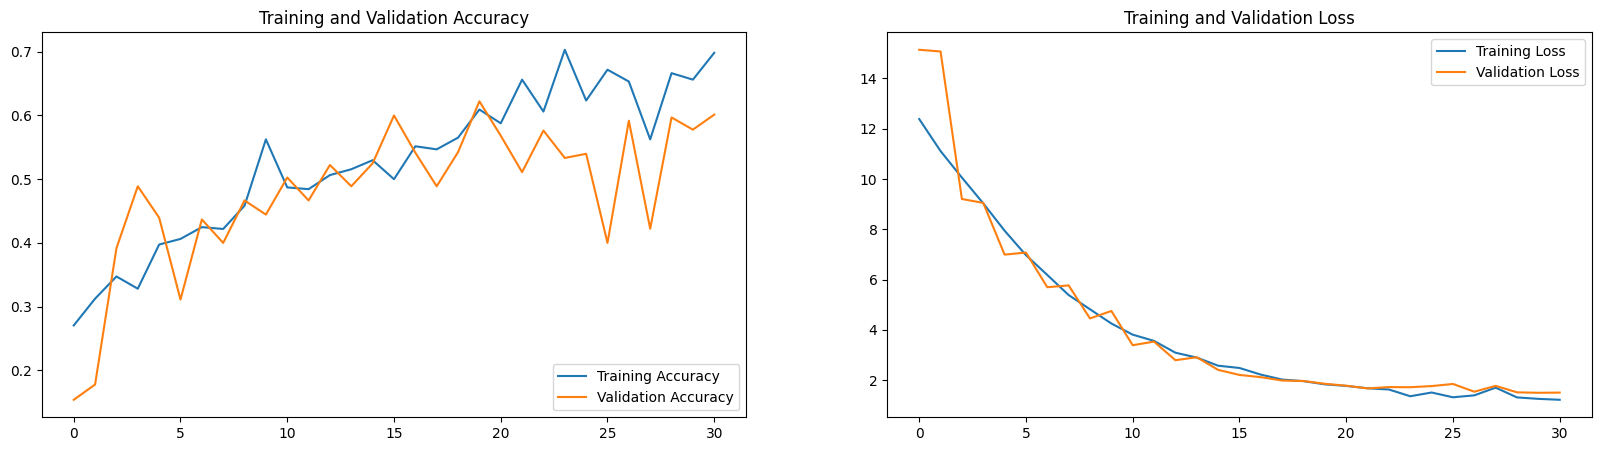

In [26]:
def plot_training_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    
plot_training_history(history)

### Model Evaluation

In [27]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.7741 - loss: 1.0652
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.5984 - loss: 1.5182
final train accuracy = 77.17 , validation accuracy = 59.14


113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step


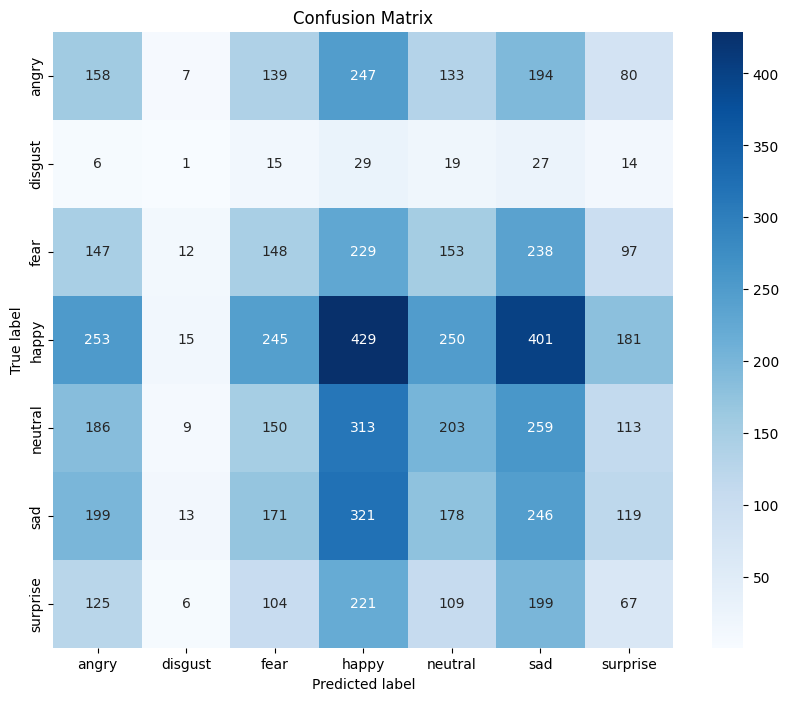

In [28]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

# Plotting cm with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
# The classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.16      0.16       958
     disgust       0.02      0.01      0.01       111
        fear       0.15      0.14      0.15      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.19      0.16      0.18      1233
         sad       0.16      0.20      0.18      1247
    surprise       0.10      0.08      0.09       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



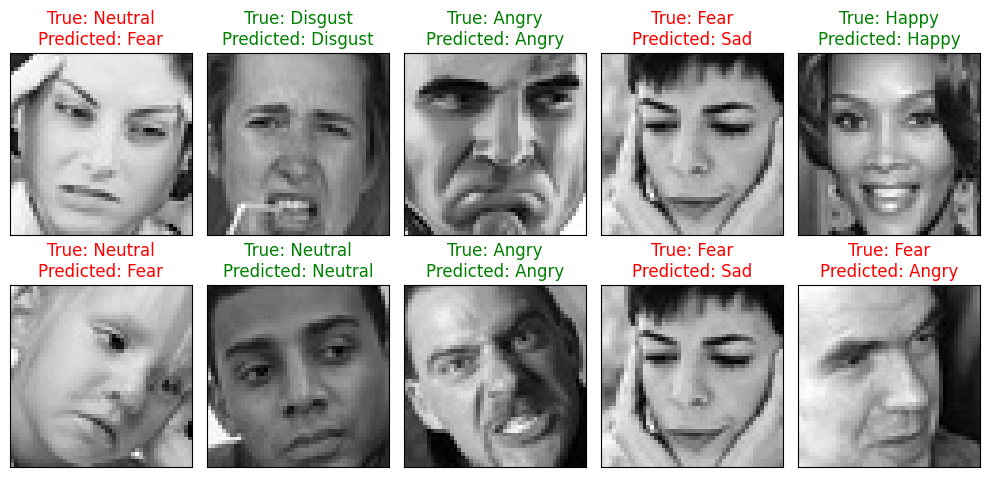

In [31]:
# Emotion classes in the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Batch size of test generator
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()